# 02807 Computational Tools for Data Science
##### November 28, 2023
__*Authors*__
- Vidisha Sinha - s204081
- David van Scheppingen - s222902
- Ari Goldhar Menachem - s163956
- Magnus Nikolaj Nyholm Jensen - s184677
***


In [1]:
import os
import math
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import cm, ticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from collections import Counter
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import warnings
from wordcloud import WordCloud
from datetime import datetime
from datetime import datetime, timedelta
import dateutil.parser
import seaborn as sns
import time
warnings.filterwarnings("ignore")

### TF-IDF class

In [2]:
class TFIDF:

    def __init__(self, df):
        self.df = df
        try:
            nltk.download('stopwords') # Download necessary NLTK resources to remove stop words
        except nltk.exceptions.AlreadyDownloaded:
            # Handle the case where the resource is already downloaded
            pass
    def preprocess_articles(self, text):
        text = text.lower() # Convert data to lover case to remove multiple occurences of the same word
        text = re.sub(r'[^a-z\s]', '', text) # Remove special characters, digits and white space using regex expression
        stop_words = set(stopwords.words('english')) # Import stop words from nltk library
        words = [word for word in text.split() if word not in stop_words] # Extract all words that are not stop words
        stemmer = PorterStemmer() # Apply stemming using nltk PorterStemmer
        stemmed_words = [stemmer.stem(word) for word in words]
        return ' '.join(stemmed_words)

    def preprocess_text_lowercase(self, text):
        # Converts to lowercase, removes symbols and stopword, but does not stem
        # Used for wordclouds
        text = text.lower()
        # Remove special characters, digits and white space using regex expression
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in text.split() if word not in stop_words]
        return ' '.join(tokens)

    # Create vocabulary of words from news articles
    def vocabulary(self, docs):
        vocab = set()
        for doc in docs:
            for word in doc:
                vocab.add(word)
        return sorted(vocab)

    # Calculate Term frequency
    def term_frequency(self, docs, vocab):
        tf = pd.DataFrame(0, index=range(len(docs)), columns=vocab)
        for i, document in enumerate(docs):
            num_words_doc = len(document)
            for word in document:
                tf.at[i, word] += document.count(word)/num_words_doc
        return tf

    # Inverse Document Frequency
    def inverse_document_frequency(self, docs, vocab):
        # We want to reduce the weight of terms that appear frequently in our collection of articles.
        idf = pd.Series(0, index=vocab) # Create series and set all elements to 0
        for word in vocab:
            counter = 0
            for doc in docs:
                if word in doc:
                    counter +=1
            idf[word] = np.log((len(docs))/(counter+1)) #TFIDF as stated in the slides of week 1
        return idf

    # TF-IDF
    def tf_idf(self, tf, idf, docs, vocab):
        tfidf = pd.DataFrame(index=range(len(docs)), columns=vocab)  # Create an empty DataFrame
        for i in range(len(docs)):
            tfidf.iloc[i] = tf.iloc[i]*idf  # Multiply TF values by IDF for each term
        tfidf = normalize(tfidf, norm='l2', axis=1)  # L2 normalization to scale vectors
        tfidf = pd.DataFrame(tfidf, columns=vocab)
        return tfidf

    def fit(self):
        # Apply preprocesing to news articles
        self.df['preprocessed_content'] = self.df['content'].apply(self.preprocess_articles)
        self.df['content_lowercase'] = self.df['content'].apply(self.preprocess_text_lowercase)
        content_lowercase_dataframe = self.df['content_lowercase'] # pd.DataFrame()
        content_lowercase_dataframe = pd.DataFrame(content_lowercase_dataframe)
        # Extract words from each news articles
        docs = self.df['preprocessed_content'].str.split()
        # Create a vocabulary corresponding to all the words in every news article
        vocab = self.vocabulary(docs)
        # Calculate the TF
        tf = self.term_frequency(docs, vocab)
        # Calculate the IDF
        idf = self.inverse_document_frequency(docs, vocab)
        # Multiply TF with IDF and calculate TF-IDF
        tfidf = self.tf_idf(tf, idf, docs, vocab)
        return tfidf, content_lowercase_dataframe

### K-means clustering class

In [3]:
class KMeansAlgorithm:

    def __init__(self, X, k, max_iterations=100):
      self.X = X.values
      self.k = k
      self.max_iterations = max_iterations
      self.centroids = None
      self.num_articles = X.shape[0]

    def init_random_centroids(self):
      # Initializing KMeans by choosing random centroids
      idx = np.random.choice(self.num_articles, size=self.k, replace=False) # Extract random indices from dataframe
      centroids = self.X[idx] # Pick random rows from the dataframe
      return centroids

    def calculate_euclidean_distances(self):
      # Calculate distances from vector/row to centroid
      num_centroids = self.centroids.shape[0]
      distances = np.zeros((num_centroids, self.num_articles))

      for centroid_idx in range(num_centroids):
          for article_idx in range(self.num_articles):
              distances[centroid_idx, article_idx] = np.sqrt(np.sum((self.centroids[centroid_idx, :] - self.X[article_idx, :]) ** 2))
      return distances

    def update_centroids(self, labels):
        # Calculate the mean of each cluster as new centroid
        new_centroids = []
        for k in range(self.k):
            mean = self.X[labels == k].mean(axis=0)
            new_centroids.append(mean)
        new_centroids = np.array(new_centroids)
        return new_centroids

    def plot_clusters(self, labels, centroids, iteration):
        # We will use PCA to plots clusters as the TFIDF matrix has many dimensions
        unique_labels = np.unique(labels)
        pca = PCA(n_components=3)
        data_3d = pca.fit_transform(self.X)
        centroids_3d = pca.transform(centroids)
        # 3D plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        color_map = cm.get_cmap('turbo', len(unique_labels))
        # Plot data
        for label in unique_labels:
            indices = labels == label # like [1, 2, 1, 3, 1]
            ax.scatter(data_3d[indices, 0], data_3d[indices, 1], data_3d[indices, 2], label=f'Cluster {label}', c=[color_map(label)])
        # Plot centroids
        ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='red', marker='x', s=80, label='Centroids')
        # ax.set_title(f'PCA 3D - iteration {iteration}')
        ax.set_xlabel('Principal component 1')
        ax.set_ylabel('Principal component 2')
        ax.set_zlabel('Principal component 3')
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
        clear_output(wait=True)
        plt.show()
        fig.savefig('figures/PCA-plot.png', bbox_inches='tight', pad_inches=0.25)

    def fit(self):
      print("Clustering: KMeans fit()", datetime.now().strftime("%H:%M:%S"))

      # Run the Kmeans algorithm using helper functions
      self.centroids = self.init_random_centroids() # Init centroids

      for i in range(self.max_iterations):
        distances = self.calculate_euclidean_distances() # calculate eucledian distances
        labels = np.argmin(distances, axis=0) # Assign to the cluster with the centroid that has the minimum distance to that point
        new_centroids = self.update_centroids(labels) # Calculated centroids based on mean of the points in that cluster

        if np.all(new_centroids == self.centroids): # If no new centroids break loop
          print("Clustering: Kmeans has converged!", datetime.now().strftime("%H:%M:%S"))
          break

        self.centroids = new_centroids
        self.plot_clusters(labels, self.centroids, i) # Plot PCA 3D plot

      return labels

In [4]:
def extract_documents(df):
    """
    Main TF-IDF Function
    Total time for 500 articles: 20 minutes

    Args:
        df (dataframe): dataframe with preprocessed content

    Returns:
        tf idf matrix
    """
    tfidf = TFIDF(df)
    tfidf_matrix, content_lowercase_dataframe = tfidf.fit()

    return tfidf_matrix, content_lowercase_dataframe

def Cluster_Articles(k, data):
    """Main cluster articles function

    Args:
        k (int): nr clusters
        data (dataframe): PD dataframe with contents, etc.

    Returns:
        dataframe: df with ['clusters'] appended
    """
    tfidf_matrix, dummy = extract_documents(data)
    Kmeans = KMeansAlgorithm(tfidf_matrix, k) # Optimal number of clusters is determined from the results of the elbow method
    labels = Kmeans.fit()
    data['cluster'] = labels
    return data

def elbow_method(data):
    # We will use elbow method to determine optimal number of clusters
    num_clusters = range(1, 31)
    wcss = []

    for k in num_clusters:
        # We will use Sklearn's Kmeans algorithm, but use random intialization as used in our implementation
        kmeans = KMeans(n_clusters=k, init='random', random_state=123)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method
    fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True, sharey=True)
    lines = plt.plot(num_clusters, wcss)
    plt.setp(lines, color='tab:grey', linewidth=3.0, linestyle='-', marker='s', markerfacecolor='C0', markeredgecolor='k',  markersize=7.5)
    # plt.annotate('Elbow', xy=(10, 86.25), xytext=(12, 90), arrowprops=dict(facecolor='black', shrink=0.05))
    # plt.title('Elbow Method - KMeans with random initialization')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.show()
    fig.savefig('figures/elbow-plot.png', bbox_inches='tight', pad_inches=0.25)

In [5]:
def generate_wordclouds(content_lowercase_dataframe, cluster_labels):
    # Create dataframe with cluster numbers as columns and individual articles as rows
    # The (lowercase) content of each article will be assigned to the corresponding row (article) and column (cluster) of the dataframe
    # Remaining cells will be null
    clusters_dataframe = pd.DataFrame()

    list_to_append = [] # Row of null values that can be appended to dataframe

    for i in range(len(np.unique(cluster_labels))):
        clusters_dataframe[str(i)] = ''
        list_to_append.append(np.nan)

    # Looping through the cluster labels of all articles
    for i in range(len(cluster_labels)):
        # Initialize row with null values
        clusters_dataframe.loc[len(clusters_dataframe.index)] = list_to_append
        # Add article to the cluster it belongs to in the dataframe
        clusters_dataframe.loc[i,str(cluster_labels[i])] = content_lowercase_dataframe.loc[i,'content_lowercase']

    # display(clusters_dataframe.shape)

    # This DataFrame has only one row, and the same number of columns as there are clusters.
    # Every column contains ALL the text of a given cluster.
    text_cluster_df = pd.DataFrame()

    list_to_append = [] # Row of null values that can be appended to dataframe

    for i in range(clusters_dataframe.shape[1]):
        text_cluster_df[str(i)] = ''
        list_to_append.append(np.nan)

    # Initialize first row
    text_cluster_df.loc[len(text_cluster_df.index)] = list_to_append

    # text_cluster_df.head()

    text = []
    # Outer loop: The number of clusters
    for i in range(clusters_dataframe.shape[1]):
        # Inner loop: Number of articles
        for j in range(clusters_dataframe.shape[0]):
            if (pd.notnull(clusters_dataframe.loc[j,str(i)])):
                # If the field is not null, then append the text to be added for the given cluster
                text.append(clusters_dataframe.loc[j,str(i)])
        text_cluster_df.loc[0, str(i)] =  ' '.join(text)
        text = []

    # WORDCLOUD
    wordclouds = []
    for i in range(text_cluster_df.shape[1]):
        text = text_cluster_df.loc[0,str(i)]
        # Create and generate a word cloud image:
        wordcloud = WordCloud(max_font_size=50, max_words=15, background_color="white").generate(text)
        wordclouds.append(wordcloud)

    plt.figure(figsize=(17, 17))
    for n, cloud in enumerate(wordclouds):
        # add a new subplot iteratively
        ax = plt.subplot(7, 3, n + 1)
        ax.imshow(cloud, interpolation="bilinear")
        ax.set_xlabel(str(n+1), fontsize=18)
        plt.xticks([])
        plt.yticks([])

    plt.savefig('figures/wordclouds-nolib.png', bbox_inches='tight', pad_inches=0.25)

### Load datasets to analyze
- One or more datasets can be loaded.

## Running TF-IDF

### Process Similar Articles

### Determine number of clusters
- The number of clusters is determined using the elbow method.

In [6]:
def preprocess_text_lowercase_df(data):
    articles = data.shape[0]
    lowercase_list = []
    for i in range(articles):
        text = data.loc[i,'content']
        text = text.lower()
        # Converts to lowercase, removes symbols and stopword, but does not stem
        # Used for wordclouds
        # Remove special characters, digits and white space using regex expression
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in text.split() if word not in stop_words]
        lowercase_article = ' '.join(tokens)
        lowercase_list.append(lowercase_article)
    lowercase_dataframe = pd.DataFrame()
    lowercase_dataframe['content_lowercase'] = lowercase_list
    return lowercase_dataframe

In [7]:
# dataset_paths = [file for file in os.listdir("./data/") if file.endswith(('csv'))] # Select all available data files
# dataset_paths = ["scraping_data_filtered.csv"]
dataset_paths = ["Monday_new_scraping_data_filtered_clustered11.csv"]
# dataset_paths = ["articles1.csv"]

# Load data
data_frames = []
data = []
DATA_LIMIT = 500 # how many items to load
for data_path in dataset_paths:
    data_frames.append(pd.read_csv(os.path.join('./data/', data_path)).head(DATA_LIMIT))
data = pd.concat(data_frames)


# data_new = data.drop(['Unnamed: 0', 'date', 'url', 'cluster', 'event', 'summary'], axis=1, errors='ignore')

if len(data) > 0:
        # display dataframe header
        print("First 20 entries in data (size " + str(len(data)) + "):")
        display(data.head(20))

First 20 entries in data (size 449):


,Unnamed: 0,name,title,url,author,content,date,day,month,year,preprocessed_content,cluster,event,summary
0,0,NY Post,Two in custody after allegedly attacking Jewis...,https://nypost.com/2023/11/27/metro/2-women-ar...,Amanda Woods,Two women have been slapped with hate crime ch...,"Nov. 27, 2023, 1:15 p.m. ET",27,11,2023,two women slap hate crime charg forallegedli a...,6,0,-
1,1,NY Post,Hamas frees 11 more hostages as US hopes two A...,https://nypost.com/2023/11/27/news/hamas-set-t...,Ronny Reyes,Hamas freed11 more Israeli hostages— nine chil...,"Nov. 27, 2023, 2:01 p.m. ET",27,11,2023,hama freed isra hostag nine children two mothe...,0,2,Israeli military confirms the nearly dozen kid...
2,2,NY Post,NBA star at risk of losing $40 million over al...,https://nypost.com/2023/11/27/sports/josh-gidd...,Jenna Lemoncelli,Oklahoma City Thunder guard Josh Giddey is re...,"Nov. 27, 2023, 1:35 p.m. ET",27,11,2023,oklahoma citi thunder guard josh giddey report...,5,0,-
3,3,NY Post,Frosty the Joe-man: White House Christmas part...,https://nypost.com/2023/11/27/news/white-house...,Steven Nelson,WASHINGTON — A large number of White House rep...,"Nov. 27, 2023, 3:09 p.m. ET",27,11,2023,washington larg number white hous report snub ...,0,3,-
4,4,NY Post,Dave Portnoy quits gambling again after NFL he...,https://nypost.com/2023/11/27/sports/dave-port...,Erich Richter,It is the end of an era. Notorious gambler an...,"Nov. 27, 2023, 1:18 p.m. ET",27,11,2023,end era notori gambler barstool sport founder ...,5,0,-
5,5,NY Post,'Squad' silent after anti-Israel group points ...,https://nypost.com/2023/11/27/news/squad-silen...,Josh Christenson,A human rights organization with a long histor...,"Nov. 27, 2023, 3:26 p.m. ET",27,11,2023,human right organ long histori antiisrael stat...,0,0,-
6,6,NY Post,Prince William has 'no plans' to see Harry aga...,https://nypost.com/2023/11/27/entertainment/pr...,Jack Hobbs,It’s a tale of two brothers. Royal expert Sara...,"Nov. 27, 2023, 1:36 p.m. ET",27,11,2023,tale two brother royal expert sarah hewson cla...,2,0,-
7,7,NY Post,Disney employee racks up $24K on corporate car...,https://nypost.com/2023/11/27/business/disney-...,Alexandra Steigrad,"A Disneyland employee who spent $24,000 on hi...","Nov. 27, 2023, 12:49 p.m. ET",27,11,2023,disneyland employe spent corpor credit card fu...,6,0,-
8,8,NY Post,Common cleaner no longer strong enough to kill...,https://nypost.com/2023/11/27/lifestyle/common...,Alex Mitchell,It’s not good news. New research shows that so...,"Nov. 27, 2023, 2:19 p.m. ET",27,11,2023,good news new research show use hospit cleaner...,10,0,-
9,9,NY Post,Amazon's Cyber Monday blowout: 55+ incredible ...,https://nypost.com/shopping/amazon-cyber-monda...,Victoria Giardina,"As you can imagine,Amazonhas a widespread col...","Nov. 27, 2023, 8:05 a.m. ET",27,11,2023,imagineamazonha widespread collect even that u...,6,0,-


In [8]:
# data = pd.read_csv("data/Monday_new_scraping_data_filtered_clustered11.csv")

# data['content'] = data['content'].astype(str)
# print(data.shape)
# # Convert the column to numeric, errors='coerce' will replace non-numeric values with NaN
# data['cluster'] = pd.to_numeric(data['cluster'], errors='coerce')

# # Drop rows with NaN values in the specified column
# data = data.dropna(subset=['cluster'])

# # Convert the column to integer type
# data['cluster'] = data['cluster'].astype(int)
# print(data.shape)
# data_temp = data.drop(['Unnamed: 0', 'date', 'url', 'cluster', 'event', 'summary'], axis=1, errors='ignore')
# print(data_temp.shape)
# # display(type(data))
# # display(type(data_temp.copy()))
# display(type(data.loc[0,'cluster']))

In [9]:
data['content'] = data['content'].astype(str)
content_lowercase_dataframe = pd.DataFrame()
content_lowercase_dataframe = preprocess_text_lowercase_df(data)
display(content_lowercase_dataframe.head())
print(content_lowercase_dataframe.shape)

,content_lowercase
0,two women slapped hate crime charges forallege...
1,hamas freed israeli hostages nine children two...
2,oklahoma city thunder guard josh giddey report...
3,washington large number white house reporters ...
4,end era notorious gambler barstool sports foun...


(449, 1)


In [10]:
# Convert the column to numeric, errors='coerce' will replace non-numeric values with NaN
data['cluster'] = pd.to_numeric(data['cluster'], errors='coerce')

# Drop rows with NaN values in the specified column
data = data.dropna(subset=['cluster'])

# Convert the column to integer type
data['cluster'] = data['cluster'].astype(int)

In [11]:
# tfidf_dataframe, content_lowercase_dataframe = extract_documents(data_temp.copy())

# elbow_method(tfidf_dataframe)

In [12]:
nr_clusters = 11 # Number of clusters

# clustered_data = pd.DataFrame()

# data_temp = Cluster_Articles(k=int(nr_clusters), data=data_temp.copy())

cluster_labels = data['cluster'].to_numpy()

if 'cluster' in data:
    # display dataframe header
    print("First 20 entries in data with clusters:")
    display(data[['title', 'cluster']].head(5))

    # Save clusters
    # clustered_path = text_area("Path", value="clustered_articles1.csv")
    # data.to_csv(os.path.join("data/", str(clustered_path)))

First 20 entries in data with clusters:


,title,cluster
0,Two in custody after allegedly attacking Jewis...,6
1,Hamas frees 11 more hostages as US hopes two A...,0
2,NBA star at risk of losing $40 million over al...,5
3,Frosty the Joe-man: White House Christmas part...,0
4,Dave Portnoy quits gambling again after NFL he...,5


In [13]:
type(data.loc[2,'cluster'])

numpy.int32

In [14]:
display(cluster_labels)

array([ 6,  0,  5,  0,  5,  0,  2,  6, 10,  6,  5,  9,  9,  6,  3,  3,  1,
        0,  0,  1,  5,  6,  4,  9,  7,  7,  9,  7,  7,  4,  1,  7,  0,  1,
        9,  6,  4,  6, 10,  9,  9,  9,  5,  9,  6,  5, 10,  8,  4,  5,  3,
        7,  9,  4,  1,  6,  5,  5,  6,  6,  5,  9,  6,  5,  5,  9,  0,  9,
        7,  0,  5,  9, 10,  1, 10,  5,  9,  1,  3,  9,  8,  8,  1,  4,  0,
        6,  5,  7,  6,  4,  0,  9,  4,  8,  8,  3,  5,  4,  5, 10,  1,  6,
       10,  5,  8,  6,  8,  9, 10,  9,  4,  3,  9,  5,  9,  0,  0,  0,  0,
        0,  0,  4,  9,  0,  9,  9,  4,  5,  1,  5,  0,  1,  6,  3,  9,  9,
        8,  9,  4,  8,  6,  6,  4,  1,  3,  5,  6,  6,  6,  6,  4,  1,  9,
        9,  9,  3,  6,  5,  5,  5,  7,  9,  8,  8,  1,  6,  1,  8,  0,  9,
        9,  6,  9,  0,  9,  0,  1,  4,  9,  6,  4,  3,  9,  1,  6,  3,  8,
        5,  9,  6,  8,  5,  9,  5,  5,  3,  3,  1,  3,  8,  3,  1,  9,  9,
        4,  9,  3,  4,  9,  3,  4,  6,  9,  9,  3, 10,  8,  9,  3,  6,  6,
        7, 10,  3,  9,  9

### Generating wordclouds for each cluster

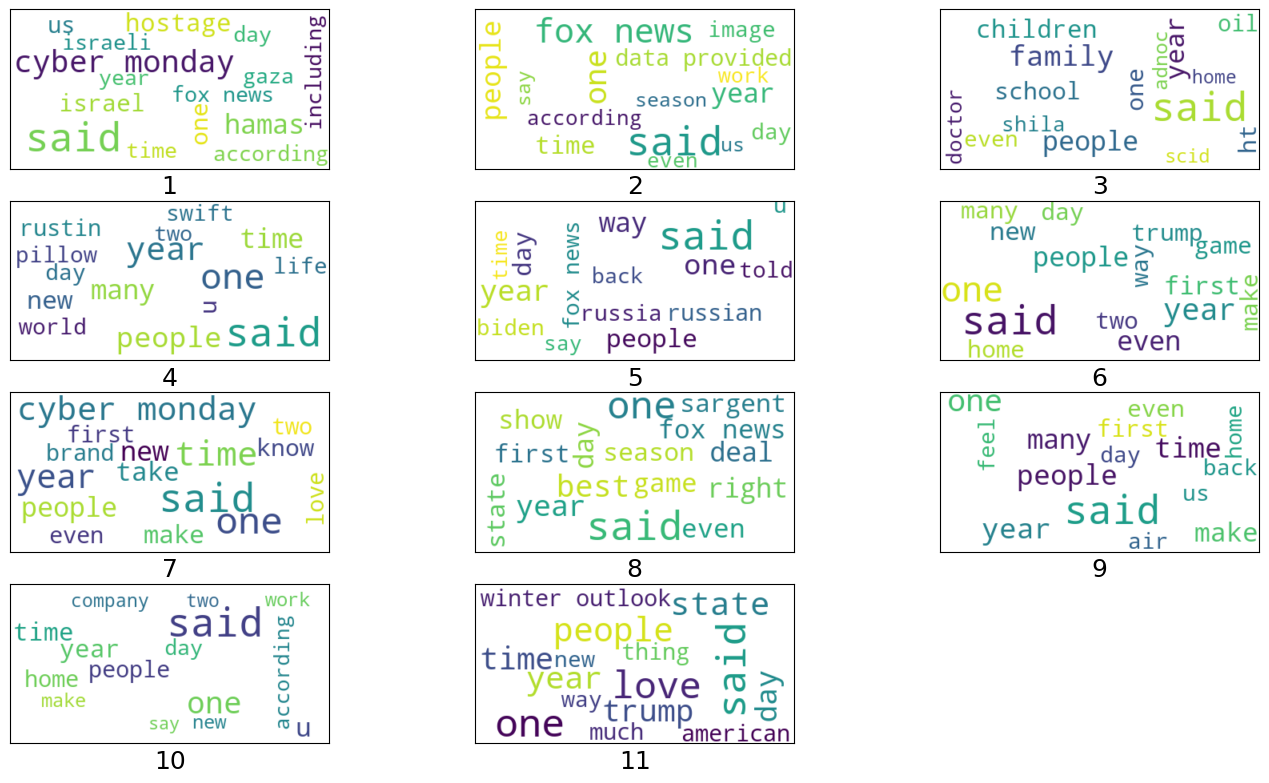

In [15]:
generate_wordclouds(content_lowercase_dataframe, cluster_labels)